!pip install --upgrade torch torchvision --user
pip install torch
pip install numpy
pip install requests
!pip install tf2onnx
!pip install onnxruntime
pip install onnx
pip install onnxruntime
pip install onnx_tf
!pip install tensorflow
pip install tensorflow_probability

In [15]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

img = read_image("49.jpg")

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

cheeseburger: 49.2%


In [16]:
import onnx
import torch

example_input = torch.rand(1, 3, 224, 224)  # exmample for the forward pass input 
pytorch_model = model
model.eval()
ONNX_PATH="./my_model.onnx"

torch.onnx.export(
    model=pytorch_model,
    args=example_input, 
    f=ONNX_PATH, # where should it be saved
    verbose=False,
    export_params=True,
    do_constant_folding=False,  # fold constant values for optimization
    # do_constant_folding=True,   # fold constant values for optimization
    input_names=['input'],
    output_names=['output']
)
onnx_model = onnx.load(ONNX_PATH)
onnx.checker.check_model(onnx_model)

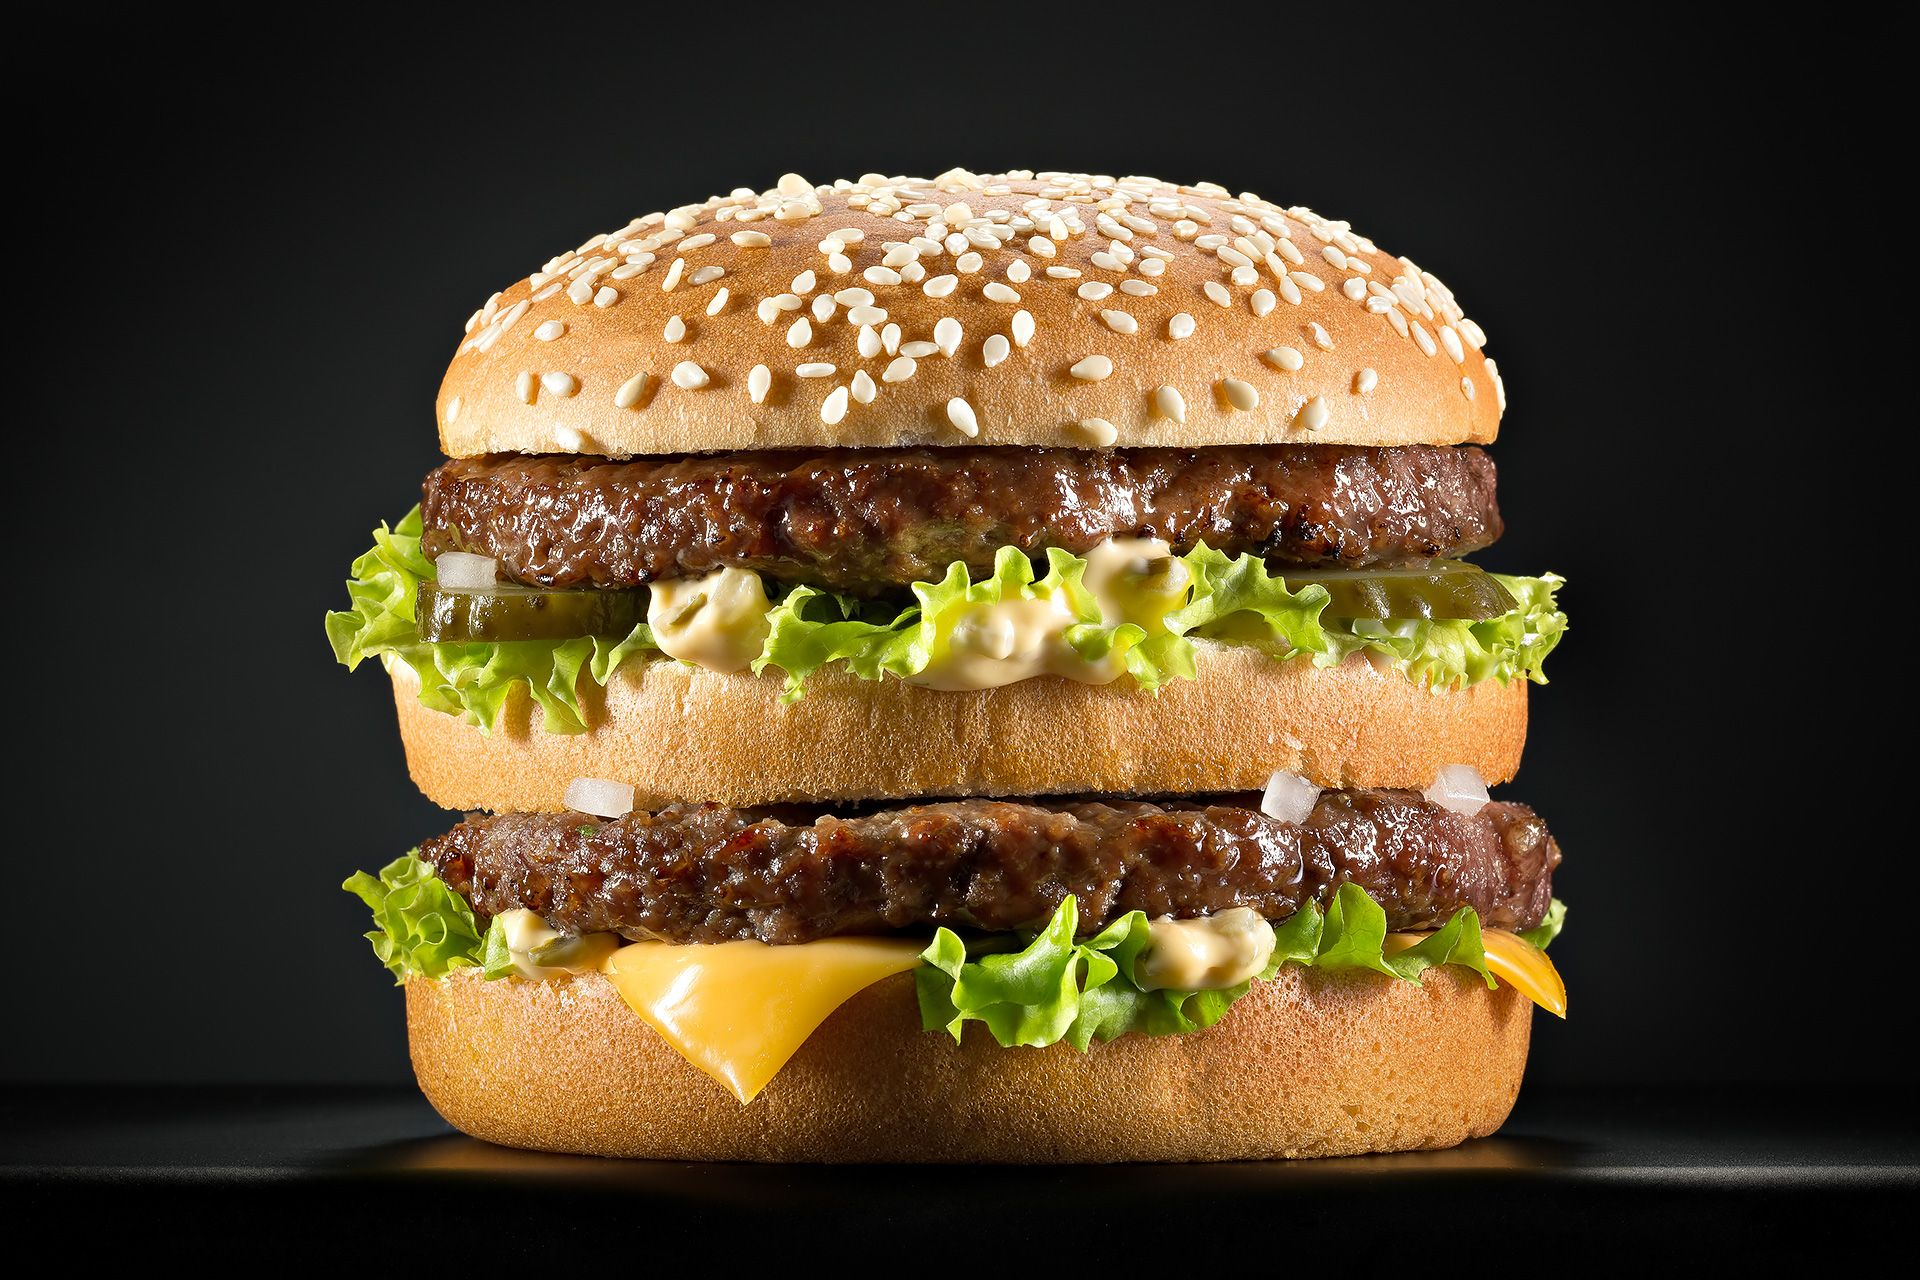

In [17]:
from PIL import Image
img_path = "49.jpg"
# torch.hub.download_url_to_file("https://www.google.com/search?q=pug&sxsrf=ALiCzsYTdIB1rxHngO5Eh90duuXzDODAMQ:1666776618879&source=lnms&tbm=isch&sa=X&ved=2ahUKEwjn66biyv36AhXWmosKHWtGBdEQ_AUoAXoECAMQAw&biw=1536&bih=754&dpr=1.25#imgrc=dbn4Vpbu9HbudM&imgdii=MMWWD0LmwDwlEM", img_path)
img = Image.open(img_path)
img

In [20]:
from torchvision import transforms as T
trans = T.Compose([T.Resize((224, 224)), T.ToTensor()])
timg = trans(img)
out = model(timg.unsqueeze(0))
pred_i = out.argmax(dim=1)[0]
print(pred_i)

tensor(933)


In [21]:
import onnxruntime as ort
import numpy as np
#x, y = trans[0][0], trans[0][1]
ort_sess = ort.InferenceSession(ONNX_PATH)
outputs = ort_sess.run(None, {'input': np.array(timg)[None]})
outputs[0].argmax()

933

## ONNX to TensorFlow

In [22]:
import onnx
from onnx_tf.backend import prepare

tf_model_path = "./my_tf_model" # where the representation of tensorflow model will be stored
ONNX_PATH = "./my_model.onnx" # path to my existing ONNX model
onnx_model = onnx.load(ONNX_PATH)  # load onnx model

# prepare function converts an ONNX model to an internel representation
# of the computational graph called TensorflowRep and returns
# the converted representation.
tf_rep = prepare(onnx_model)  # creating TensorflowRep object

# export_graph function obtains the graph proto corresponding to the ONNX
# model associated with the backend representation and serializes
# to a protobuf file.
tf_rep.export_graph(tf_model_path)

INFO:tensorflow:Assets written to: ./my_tf_model\assets


INFO:tensorflow:Assets written to: ./my_tf_model\assets


## TensorFlow to TensorFlow Lite

In [23]:
import tensorflow as tf
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
tflite_model = converter.convert()

tflite_model_path = "./my_tflife_model"
# Save the model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [24]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_shape = input_details[0]['shape']
input_data = np.array(timg)[None]
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# get_tensor() returns a copy of the tensor data
# use tensor() in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data[0].argmax())

933


In [25]:
np.array(timg)[None].shape

(1, 3, 224, 224)

In [26]:
input_details

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1,   3, 224, 224]),
  'shape_signature': array([  1,   3, 224, 224]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

## Custom model

In [17]:
import onnx
import torch

In [18]:
my_model = torch.hub.load('ultralytics/yolov5', 'custom', 'C:/Users/PC/LABS/MNN/lab03/Image_Set/yolov5/runs/train/exp2/weights/best.pt')

Using cache found in C:\Users\PC/.cache\torch\hub\ultralytics_yolov5_master
requirements: YOLOv5 requirements "scipy>=1.4.1" "seaborn>=0.11.0" not found, attempting AutoUpdate...
requirements:  Command 'pip install "scipy>=1.4.1" "seaborn>=0.11.0"  ' returned non-zero exit status 1.
YOLOv5  2022-10-24 Python-3.8.8 torch-1.12.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7053277 parameters, 0 gradients
Adding AutoShape... 


Saved 1 image to runs\detect\exp2


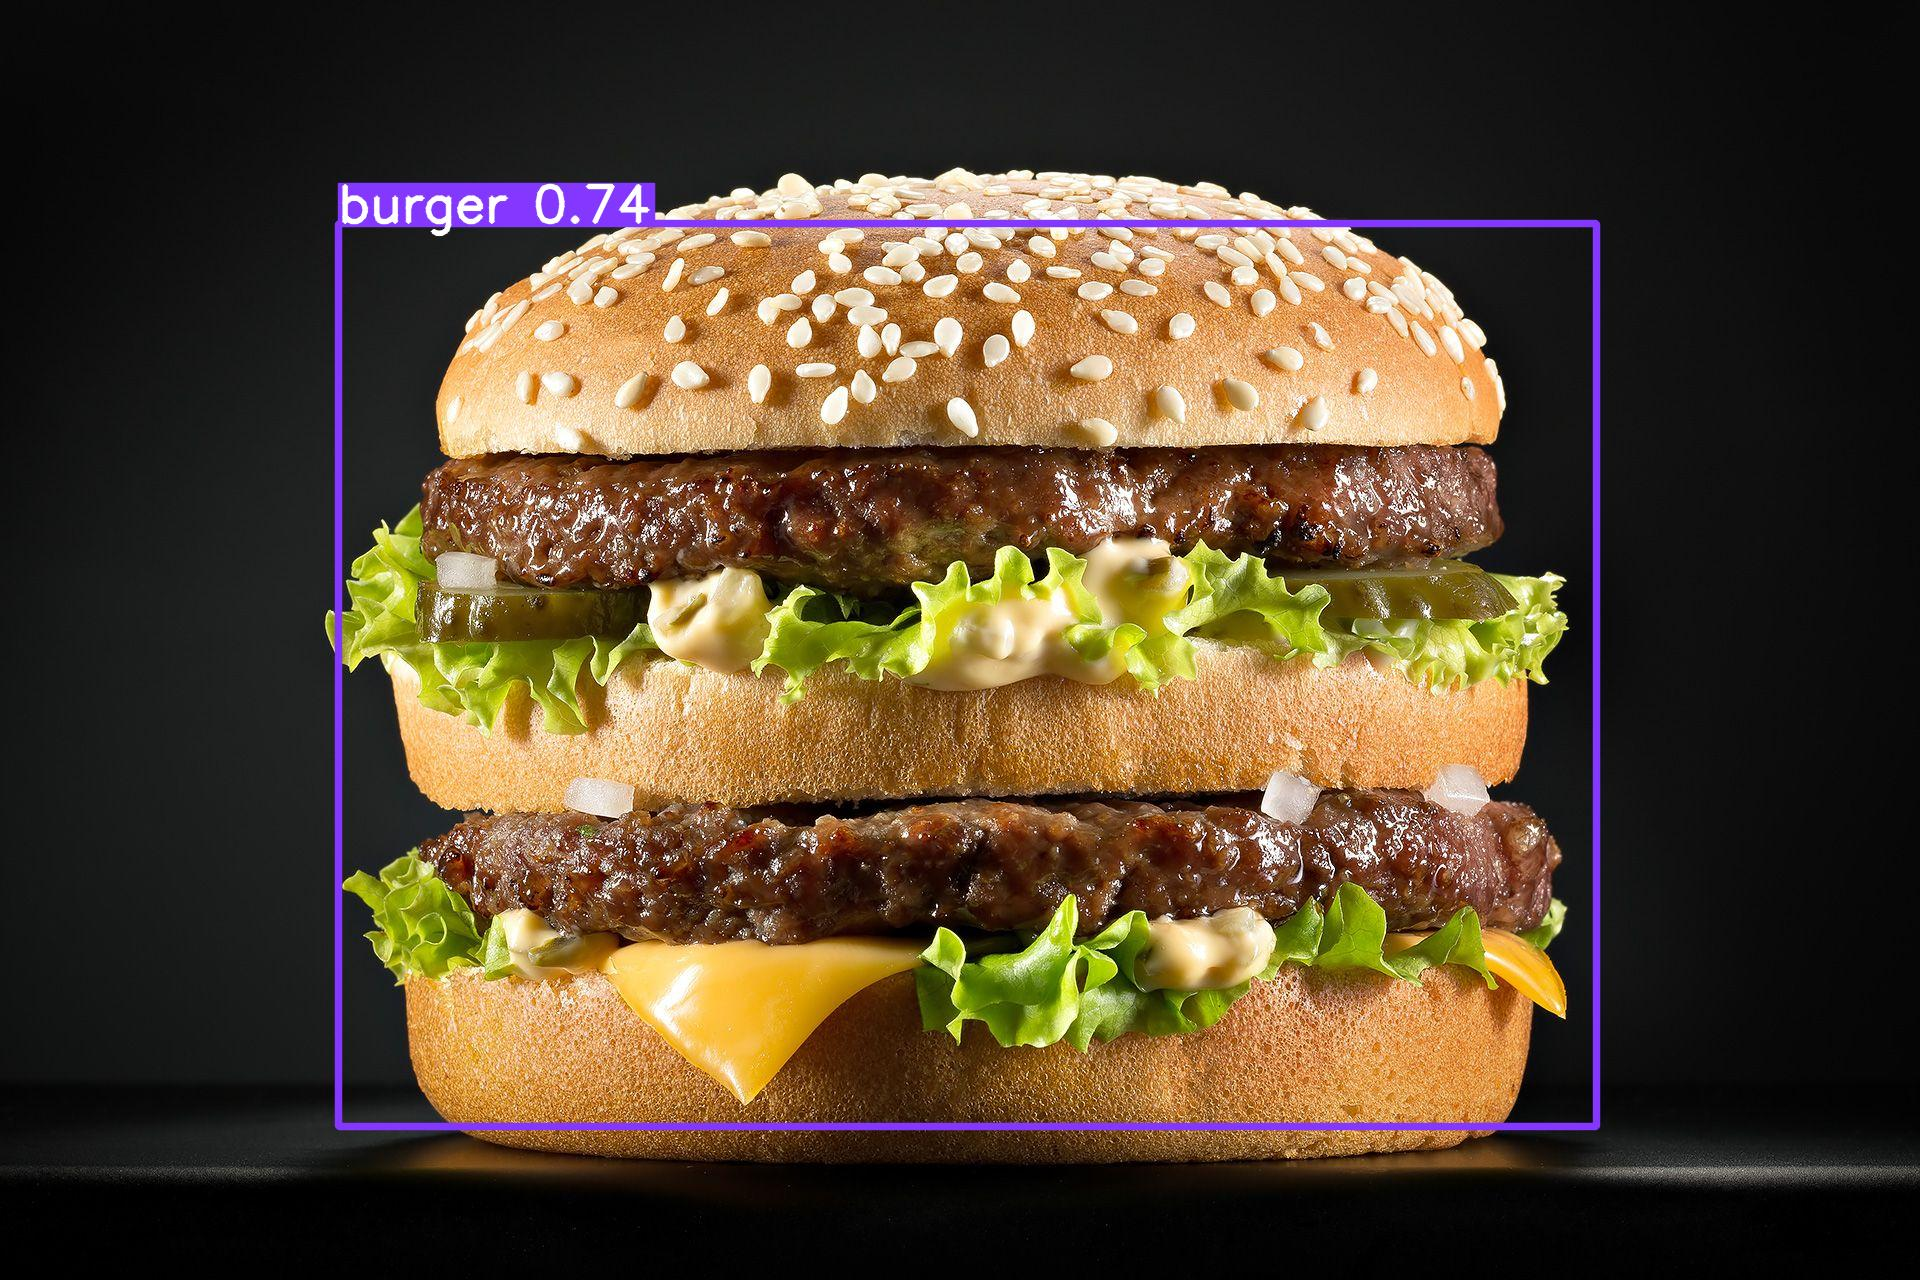

In [19]:
from PIL import Image

result = my_model('49.jpg', size=640)
result.save()
imgResult = Image.open('./runs/detect/exp/49.jpg')
imgResult

In [13]:
!python ../lab03/Image_Set/yolov5/export.py --weights ../lab03/Image_Set/yolov5/runs/train/exp2/weights/best.pt --include tflite onnx

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     


export: data=C:\Users\PC\LABS\MNN\lab03\Image_Set\yolov5\data\coco128.yaml, weights=['../lab03/Image_Set/yolov5/runs/train/exp2/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['tflite', 'onnx']
YOLOv5  v6.2-180-g82bec4c Python-3.8.8 torch-1.12.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7053277 parameters, 0 gradients

PyTorch: starting from ..\lab03\Image_Set\yolov5\runs\train\exp2\weights\best.pt with output shape (1, 25200, 21) (54.5 MB)

ONNX: starting export with onnx 1.12.0...
ONNX: export success  3.7s, saved as ..\lab03\Image_Set\yolov5\runs\train\exp2\weights\best.onnx (27.3 MB)
2022-10-24 22:42:24.363358: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart

input_1 (InputLayer)            [(1, 640, 640, 3)]   0                                            
__________________________________________________________________________________________________
tf_conv (TFConv)                (1, 320, 320, 32)    3488        input_1[0][0]                    
__________________________________________________________________________________________________
tf_conv_1 (TFConv)              (1, 160, 160, 64)    18496       tf_conv[0][0]                    
__________________________________________________________________________________________________
tf_c3 (TFC3)                    (1, 160, 160, 64)    18624       tf_conv_1[0][0]                  
__________________________________________________________________________________________________
tf_conv_7 (TFConv)              (1, 80, 80, 128)     73856       tf_c3[0][0]                      
__________________________________________________________________________________________________
tf_c3_1 (T

In [21]:
modelTFLite = torch.hub.load('ultralytics/yolov5', 'custom', '../lab03/Image_Set/yolov5/runs/train/exp2/weights/best-fp16.tflite', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\PC/.cache\torch\hub\master.zip
requirements: YOLOv5 requirements "scipy>=1.4.1" "seaborn>=0.11.0" not found, attempting AutoUpdate...

requirements: 2 packages updated per C:\Users\PC\.cache\torch\hub\ultralytics_yolov5_master\requirements.txt
requirements:  Restart runtime or rerun command for updates to take effect

YOLOv5  2022-10-27 Python-3.8.8 torch-1.12.1+cpu CPU

Loading ..\lab03\Image_Set\yolov5\runs\train\exp2\weights\best-fp16.tflite for TensorFlow Lite inference...
Adding AutoShape... 


In [22]:
from torchvision import transforms as T

mainImage = Image.open('27.jpg')

trans = T.Compose([T.Resize((640, 640))])
timgTFLite = trans(mainImage)
# out = modelTFLite(timg.unsqueeze(0))
# pred_i = out.argmax(dim=1)[0]
# print(pred_i)

In [24]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path='../lab03/Image_Set/yolov5/runs/train/exp2/weights/best-fp16.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


input_data = np.array(timgTFLite, dtype=np.float32)[None]
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# get_tensor() returns a copy of the tensor data
# use tensor() in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
result = output_data[0]

In [25]:
result[result[:, 4] > 0.99]

array([[    0.37464,     0.23715,     0.16005,     0.28067,     0.99117,    0.032071,   0.0023375,   0.0011033,  0.00036862,   0.0020387,   0.0017793,    0.011967,  6.3452e-05,  4.4389e-05,    0.032957,   0.0026062,   0.0071418,   0.0011528,  0.00040472,    0.012902,     0.99998]], dtype=float32)